In [1]:
from data import *
from train import *
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

Using TensorFlow backend.


In [2]:
df_microbioma_train, df_microbioma_test, \
df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, \
df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test,\
otu_columns, domain_columns = read_df_with_transfer_learning_subset_3domainFeatures()

In [3]:
print(df_domain_train.shape)
print(df_domain_test.shape)
print(df_domain_transfer_learning_train.shape)
print(df_domain_transfer_learning_test.shape)

(4251, 3)
(373, 3)
(70, 3)
(30, 3)


In [4]:
def make_cv_predictions(data, models):
    all_predictions = []
    for m in models:
        all_predictions.append(m.predict(data))
    return np.mean(all_predictions, axis=0)

# Linear regression transfer_learning subset (domain-microbiome)

### Get numpy transfer_learning objects

In [5]:
data_microbioma_transfer_learning_train = df_microbioma_transfer_learning_train.to_numpy(dtype=np.float32)
data_microbioma_transfer_learning_test = df_microbioma_transfer_learning_test.to_numpy(dtype=np.float32)
data_domain_transfer_learning_train = df_domain_transfer_learning_train.to_numpy(dtype=np.float32)
data_domain_transfer_learning_test = df_domain_transfer_learning_test.to_numpy(dtype=np.float32)

In [6]:
def model(shape_in, shape_out, output_transform):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    #for s in layers_list:
    #    net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [9]:
def model_fn():
    m = model(shape_in=3,
              shape_out=717,
              output_transform=None)
              #layers_list=[128,256],
              #activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [10]:
latent_space = 0
results, models = train(model_fn,
                        data_microbioma_transfer_learning_train,
                        data_domain_transfer_learning_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>99</b></p>

<b>loss</b>: 4.7702 (min: 4.6950, max: 4.9490)

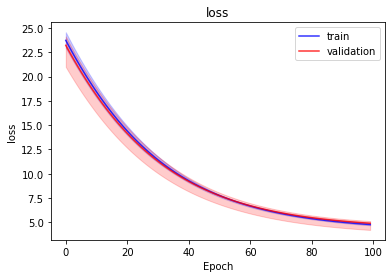

<b>domain_BrayCurtis</b>: 0.5486 (min: 0.5199, max: 0.6107)

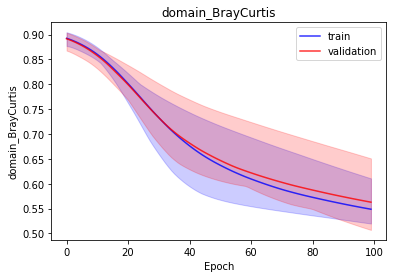

<b>domain_pearson_corr</b>: 0.5625 (min: 0.3762, max: 0.6441)

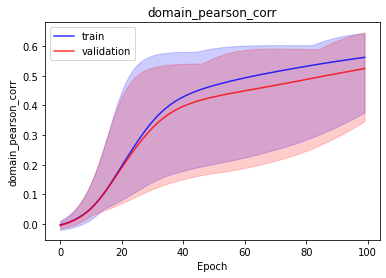

<b>domain_jensen_shannon_divergence</b>: 1.3860 (min: 1.2468, max: 1.5582)

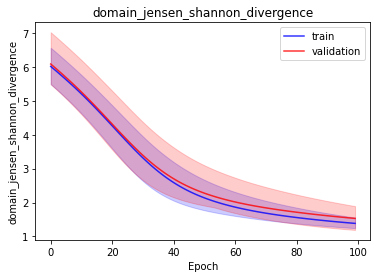

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 4.770208740234375 | 4.695002555847168 | 4.94900369644165 |
| domain_BrayCurtis | 0.5486301183700562 | 0.5198960900306702 | 0.6106730103492737 |
| domain_pearson_corr | 0.5625126361846924 | 0.37617143988609314 | 0.6440922617912292 |
| domain_jensen_shannon_divergence | 1.385970115661621 | 1.2467750310897827 | 1.5582449436187744 |


[('best_lost_epoch', 99),
 ('val_loss', [4.903912925720215, 4.217108249664307, 5.12975549697876]),
 ('val_domain_BrayCurtis', [0.56281394, 0.50699776, 0.65086883]),
 ('val_domain_pearson_corr', [0.5246717, 0.34741136, 0.64726174]),
 ('val_domain_jensen_shannon_divergence', [1.5323642, 1.1935295, 1.8952221])]

In [11]:
print_results(results)

In [12]:
def test_model(models, input_transform, output_transform, bioma_transfer_test, domain_transfer_test):
    data_bioma_test_transformed = Percentage()(bioma_transfer_test)
    if input_transform is not None:
        input_transform = input_transform()
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    all_predictions = []
    for cv_models in models:
        model, _, _, _ = cv_models
        predictions = model.predict(domain_transfer_test)
        for m in metrics:
            if m.name not in metrics_results:
                metrics_results[m.name] = []
            result = m(bioma_transfer_test, predictions)
            m.reset_states()
            metrics_results[m.name].append(result.numpy())
        predictions = tf.nn.softmax(predictions)
        all_predictions.append(predictions)
        # otus error
        se = tf.math.squared_difference(predictions, data_bioma_test_transformed)
        mse = tf.reduce_mean(se, axis=0)
        otus_errors.append(mse)
    mse_otus = tf.reduce_mean(tf.stack(otus_errors, axis=0), axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])


    display(Markdown(md_text))

    md_text ="### Best Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in mse_otus_keys[:10]:
        md_text += "| {} | {} |\n".format(k, v)
    md_text += "\n\n"
    md_text +="### Worst Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in reversed(mse_otus_keys[-10:]):
        md_text += "| {} | {} |\n".format(k, v)

    display(Markdown(md_text))
    
    final_predictions = np.mean(all_predictions,axis=0)
    return final_predictions

In [13]:
predictions = test_model(models, CenterLogRatio, None, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_linear_regresion.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.5595712661743164 | 0.5312227606773376 | 0.6340692043304443 |
| pearson_corr | 0.5435569882392883 | 0.3510879874229431 | 0.6382132172584534 |
| jensen_shannon_divergence | 1.6071207523345947 | 1.3902374505996704 | 1.7915074825286865 |


### Best Otus
| OTU | mse |
|:----|----:|
| 775149 | 9.693116448383776e-11 |
| 878714 | 1.0093516994436058e-10 |
| 915948 | 1.1263140420325612e-10 |
| 584331 | 1.1593924431618774e-10 |
| 1033380 | 1.2631755363923247e-10 |
| 216643 | 1.3568024481713792e-10 |
| 864507 | 1.456446768743902e-10 |
| 1082846 | 1.4952154792080563e-10 |
| 225453 | 1.696324608557731e-10 |
| 1049393 | 1.720660003368124e-10 |


### Worst Otus
| OTU | mse |
|:----|----:|
| 646549 | 0.07605899125337601 |
| 961783 | 0.019405506551265717 |
| 4339351 | 0.004280561115592718 |
| 527397 | 0.0020830414723604918 |
| 339660 | 0.0010090332943946123 |
| 353494 | 0.000773847452364862 |
| 849092 | 0.0004964519757777452 |
| 541511 | 0.000410815526265651 |
| 573135 | 0.00034130242420360446 |
| 571484 | 0.0003076376742683351 |


# MLP (Dense) transfer_learning subset (domain-microbiome)

In [14]:
def model(shape_in, shape_out, output_transform, layers_list, activation_fn):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    for s in layers_list:
        net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation='linear')(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [17]:
def model_fn():
    m = model(shape_in=3,
              shape_out=717,
              output_transform=None,
              layers_list=[128,256],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [20]:
data_domain_train.shape

(4251, 36)

In [22]:
latent_space=0
results, models = train(model_fn,
                        data_microbioma_transfer_learning_train,
                        data_domain_transfer_learning_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>99</b></p>

<b>loss</b>: 3.8578 (min: 3.7788, max: 4.0370)

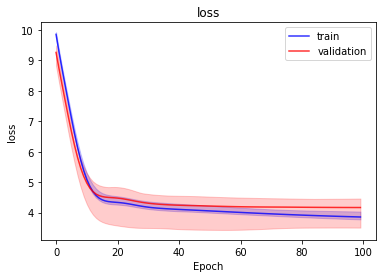

<b>domain_BrayCurtis</b>: 0.4611 (min: 0.4551, max: 0.4661)

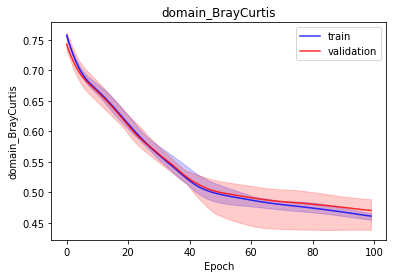

<b>domain_pearson_corr</b>: 0.6672 (min: 0.6509, max: 0.6753)

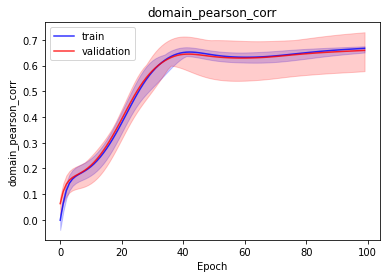

<b>domain_jensen_shannon_divergence</b>: 0.9349 (min: 0.9190, max: 0.9514)

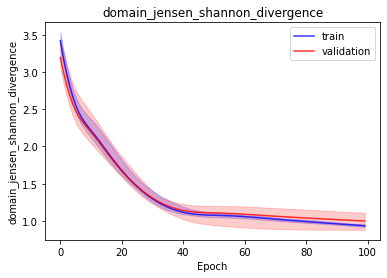

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 3.8577818870544434 | 3.7787601947784424 | 4.037007808685303 |
| domain_BrayCurtis | 0.4611359238624573 | 0.45510706305503845 | 0.4661223888397217 |
| domain_pearson_corr | 0.6671658158302307 | 0.6509472727775574 | 0.6752704381942749 |
| domain_jensen_shannon_divergence | 0.9348929524421692 | 0.9190053343772888 | 0.9513667821884155 |


[('best_lost_epoch', 99),
 ('val_loss', [4.168669605255127, 3.5088672637939453, 4.464348316192627]),
 ('val_domain_BrayCurtis', [0.47039264, 0.43868357, 0.48867917]),
 ('val_domain_pearson_corr', [0.65898025, 0.5782194, 0.72963566]),
 ('val_domain_jensen_shannon_divergence', [0.9989357, 0.8785759, 1.1089243])]

In [23]:
print_results(results)

In [25]:
predictions = test_model(models, CenterLogRatio, None, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4636029303073883 | 0.45652705430984497 | 0.4746060073375702 |
| pearson_corr | 0.6622637510299683 | 0.6465324759483337 | 0.6754720211029053 |
| jensen_shannon_divergence | 1.1461520195007324 | 1.1232818365097046 | 1.1860586404800415 |


### Best Otus
| OTU | mse |
|:----|----:|
| 510316 | 9.442849280283383e-12 |
| 813885 | 9.791946767312432e-12 |
| 1082846 | 9.957047339415048e-12 |
| 538315 | 9.962948868680321e-12 |
| 808319 | 1.0109369071031882e-11 |
| 883748 | 1.0225205231140233e-11 |
| 769643 | 1.0454538276749581e-11 |
| 1051459 | 1.0484313070491247e-11 |
| 837069 | 1.0701714688032826e-11 |
| 584331 | 1.0755103405091226e-11 |


### Worst Otus
| OTU | mse |
|:----|----:|
| 646549 | 0.032986365258693695 |
| 961783 | 0.01455516368150711 |
| 4339351 | 0.003914673812687397 |
| 527397 | 0.0006206972757354379 |
| 339660 | 0.0006075688288547099 |
| 849092 | 0.0004695453681051731 |
| 353494 | 0.00034443786717019975 |
| 541511 | 0.00033733720192685723 |
| 571484 | 0.0002996497496496886 |
| 570086 | 0.0002496997476555407 |


# Autoencoder transfer_learning subset (domain-microbiome)

### Get numpy train objects

In [27]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)

### To create auto-encoder combined model

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 10 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 5 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>89</b></p>

<b>loss</b>: 0.6259 (min: 0.6109, max: 0.6414)

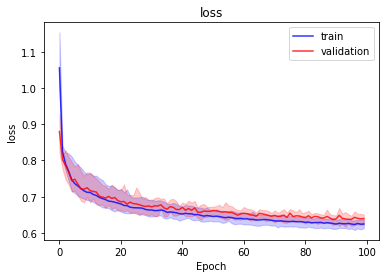

<b>bioma_loss</b>: 0.1991 (min: 0.1888, max: 0.2112)

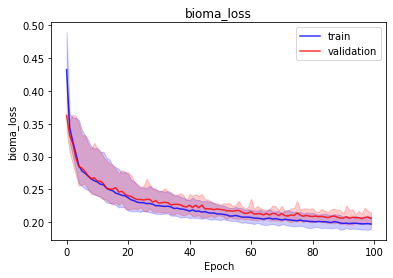

<b>domain_loss</b>: 0.4088 (min: 0.4037, max: 0.4122)

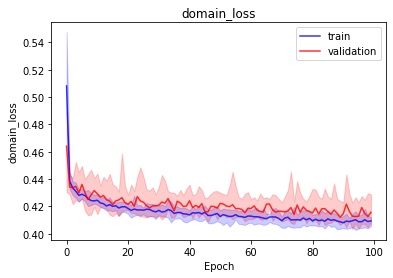

<b>latent_loss</b>: 0.0175 (min: 0.0165, max: 0.0192)

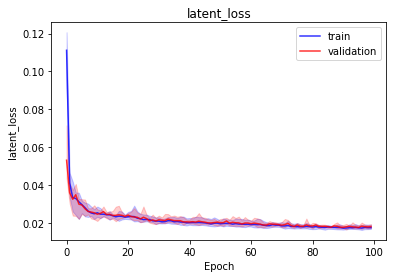

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

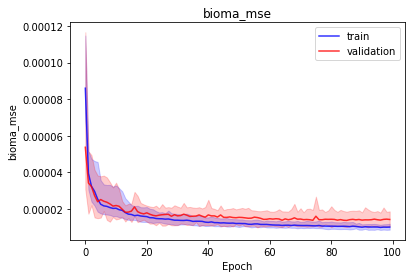

<b>bioma_mae</b>: 0.0006 (min: 0.0005, max: 0.0006)

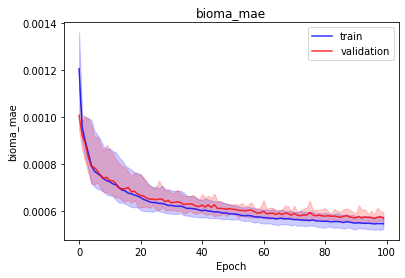

<b>bioma_mape</b>: 4861.7383 (min: 4466.8403, max: 5218.8452)

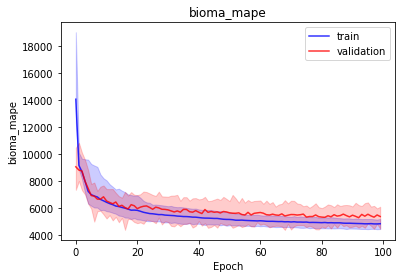

<b>bioma_BrayCurtis</b>: 0.1993 (min: 0.1894, max: 0.2115)

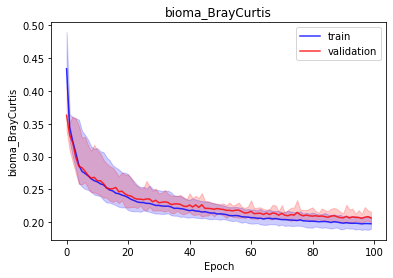

<b>bioma_pearson_corr</b>: 0.9243 (min: 0.9138, max: 0.9320)

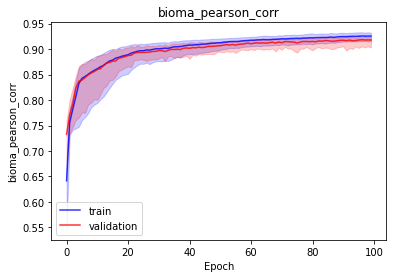

<b>bioma_jensen_shannon_divergence</b>: 0.3429 (min: 0.3142, max: 0.3753)

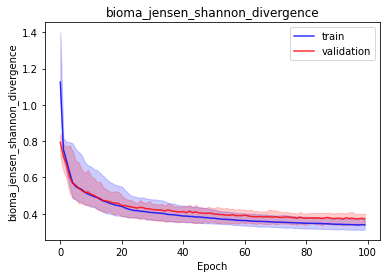

<b>domain_mse</b>: 0.0001 (min: 0.0001, max: 0.0001)

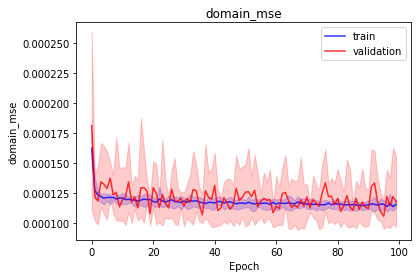

<b>domain_mae</b>: 0.0011 (min: 0.0011, max: 0.0011)

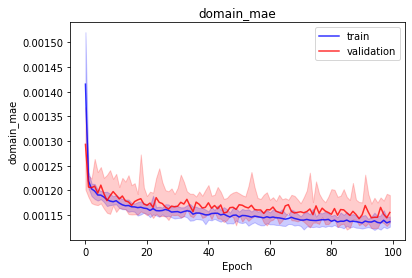

<b>domain_mape</b>: 8125.9624 (min: 7754.8394, max: 8449.3369)

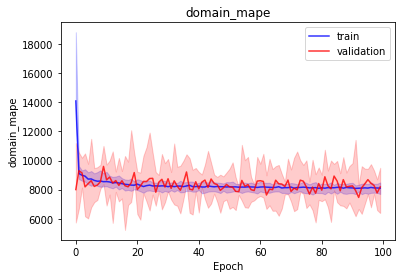

<b>domain_BrayCurtis</b>: 0.4091 (min: 0.4049, max: 0.4126)

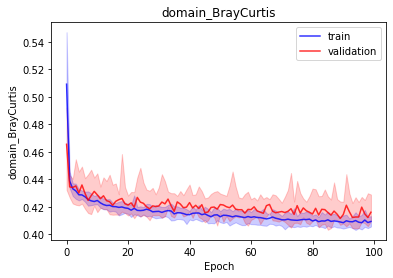

<b>domain_pearson_corr</b>: 0.7259 (min: 0.7214, max: 0.7322)

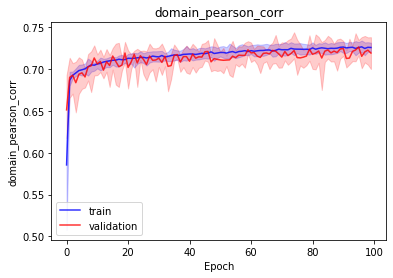

<b>domain_jensen_shannon_divergence</b>: 0.9001 (min: 0.8768, max: 0.9132)

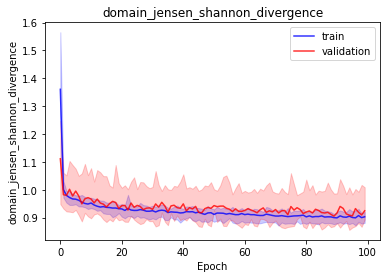

<b>latent_mae</b>: 0.0175 (min: 0.0165, max: 0.0192)

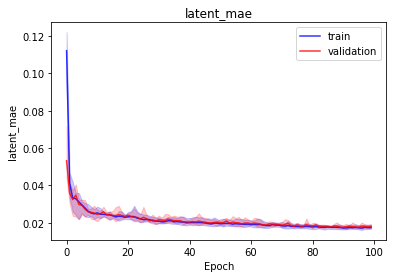

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.6259146655147098 | 0.6108821356026645 | 0.6414373601184172 |
| bioma_loss | 0.19908024370670319 | 0.1888108253479004 | 0.21122325956821442 |
| domain_loss | 0.4087517261505127 | 0.4036549925804138 | 0.41221654415130615 |
| latent_loss | 0.017529798671603203 | 0.016484390944242477 | 0.01918947882950306 |
| bioma_mse | 1.0264147022098769e-05 | 8.732823516766075e-06 | 1.2415949640853796e-05 |
| bioma_mae | 0.0005501974956132472 | 0.0005228920490480959 | 0.0005839127697981894 |
| bioma_mape | 4861.73828125 | 4466.84033203125 | 5218.84521484375 |
| bioma_BrayCurtis | 0.19928903877735138 | 0.1894446760416031 | 0.21146030724048615 |
| bioma_pearson_corr | 0.9242885708808899 | 0.913810670375824 | 0.9319733381271362 |
| bioma_jensen_shannon_divergence | 0.3428776264190674 | 0.3142445981502533 | 0.37527522444725037 |
| domain_mse | 0.00011488541349535808 | 0.00011145841563120484 | 0.00011792893201345578 |
| domain_mae | 0.0011356197064742446 | 0.0011241445317864418 | 0.0011451623868197203 |
| domain_mape | 8125.96240234375 | 7754.83935546875 | 8449.3369140625 |
| domain_BrayCurtis | 0.40908846259117126 | 0.4049171209335327 | 0.41259607672691345 |
| domain_pearson_corr | 0.7259270548820496 | 0.7214277982711792 | 0.7322152853012085 |
| domain_jensen_shannon_divergence | 0.9001094102859497 | 0.876801609992981 | 0.9132079482078552 |
| latent_mae | 0.017537152394652367 | 0.016520341858267784 | 0.01918908581137657 |


*************

In [28]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment(cv_folds=5, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh', 
                        show_results=True, 
                        device='/CPU:0')

### To get encoders and decoders to use in transfer learning model

In [29]:
encoders = []
encoders_domain = []
decoders = []
for cv_models in models:
    model, encoder, encoder_domain, decoder = cv_models
    encoders.append(encoder)
    encoders_domain.append(encoder_domain)
    decoders.append(decoder)

In [30]:
def make_cv_predictions(data, models):
    all_predictions = []
    for m in models:
        all_predictions.append(m.predict(data))
    return np.mean(all_predictions, axis=0)

### To predict latent space for samples in transfer learning Walters et al. subset

In [84]:
latent_transfer_learning_train = make_cv_predictions(data_microbioma_transfer_learning_train, encoders)
#latent_transfer_learning_train = make_cv_predictions(data_domain_transfer_learning_train, encoders_domain)
latent_transfer_learning_test = make_cv_predictions(data_microbioma_transfer_learning_test, encoders)
#latent_transfer_learning_test = make_cv_predictions(data_domain_transfer_learning_test, encoders_domain)
# target_data --> latent_transfer_learning_train
# test_data --> latent_transfer_learning_test


#Results in: latent_transfer_learning_train

In [85]:
latent_transfer_learning_train

array([[ 7.04703480e-02,  2.36560851e-01,  3.27558786e-01,
        -4.80106324e-02,  1.77191928e-01, -2.23810561e-02,
        -1.28070842e-02,  1.94845363e-01,  1.95329502e-01,
         1.28286272e-01],
       [ 4.76854071e-02,  2.28354767e-01,  3.09713870e-01,
        -2.33186428e-02,  1.81856841e-01, -2.52267066e-02,
         2.58009811e-03,  2.07716390e-01,  1.72049075e-01,
         1.29183605e-01],
       [-8.75973050e-03,  2.16145992e-01,  3.01448822e-01,
        -3.68324891e-02,  1.83448270e-01, -2.76406854e-02,
        -1.48040410e-02,  2.03521341e-01,  1.58182606e-01,
         1.67066455e-01],
       [ 4.53906767e-02,  2.22644299e-01,  3.12554657e-01,
        -2.64989492e-02,  1.79366946e-01, -2.37299222e-02,
         1.38487783e-03,  1.92356244e-01,  1.71883926e-01,
         1.38763681e-01],
       [ 1.90190412e-02,  2.23530218e-01,  3.08988124e-01,
        -3.55372019e-02,  1.81957141e-01, -2.37148739e-02,
        -1.56620033e-02,  2.02506661e-01,  1.68794274e-01,
         1.

In [88]:
latent_train = make_cv_predictions(data_microbioma_train, encoders)
#latent_train = make_cv_predictions(data_domain_train, encoders_domain)
latent_train

array([[0.03330123, 0.2277106 , 0.3066631 , ..., 0.20512128, 0.16446823,
        0.15882966],
       [0.04649652, 0.20047383, 0.34282517, ..., 0.22261319, 0.1966225 ,
        0.13962698],
       [0.07397811, 0.23399433, 0.31759018, ..., 0.20245144, 0.18345092,
        0.12162695],
       ...,
       [0.04666095, 0.22763638, 0.31253818, ..., 0.20734587, 0.17615776,
        0.13646585],
       [0.07979588, 0.23626094, 0.3205276 , ..., 0.20712683, 0.18283746,
        0.11156861],
       [0.00981794, 0.21874714, 0.30578303, ..., 0.20063272, 0.166235  ,
        0.15785775]], dtype=float32)

### To build model to predict latent space 
Dense model, with transfer_learning_train. With input=domain, output=10 neuronas latent space (activation function output=activation_latent='tanh')

In [68]:
def model_fn_tl():
    in_layer = layers.Input(shape=(36,))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    out_layer = layers.Dense(latent_transfer_learning_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [69]:
def train_tl(model_fn,
          data_encoded,
          data_domain,
          folds=5,
          epochs=100,
          batch_size=16,
          random_seed=347,
          verbose=0):
    kf = KFold(n_splits=folds, random_state=random_seed, shuffle=True)
    results = []
    models = []
    train_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs + 1, restore_best_weights=True)]
    if verbose >= 0:
        train_callbacks += [TqdmCallback(verbose=verbose)]

    tf.random.set_seed(random_seed)

    for train_index, test_index in kf.split(data_domain):
        y_train, y_test = data_encoded[train_index], data_encoded[test_index]
        x_train, x_test = data_domain[train_index], data_domain[test_index]
        model = model_fn()
        metrics_prefix = 'domain'

        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(
            batch_size)
        train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
        val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
        val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
        r = model.fit(train_dataset,
                      epochs=epochs,
                      validation_data=val_dataset,
                      callbacks=train_callbacks,
                      verbose=0)
        if metrics_prefix is not None:
            old_keys = r.history
            r.history = {}
            for k, v in old_keys.items():
                if k == 'loss' or k == 'val_loss':
                    new_key = k
                elif k.startswith('val_'):
                    new_key = 'val_{}_{}'.format(metrics_prefix, k[4:])
                else:
                    new_key = '{}_{}'.format(metrics_prefix, k)
                r.history[new_key] = v
        results.append(r)
        models.append(model)
    return results, models

In [70]:
latent_transfer_learning_train.shape

(70, 10)

In [71]:
data_domain_transfer_learning_train.shape

(70, 36)

In [72]:
results_tl, models_tl = train_tl(model_fn_tl,
                        latent_transfer_learning_train,
                        data_domain_transfer_learning_train,
                        folds=5,
                        epochs=100,
                        batch_size=16,
                        verbose=-1)

<p>Best iteration: <b>96</b></p>

<b>loss</b>: 0.0001 (min: 0.0001, max: 0.0002)

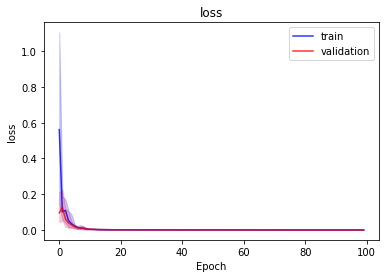

<b>domain_mean_squared_error</b>: 0.0001 (min: 0.0001, max: 0.0002)

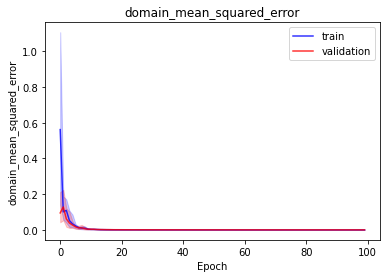

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.00011369806078229366 | 9.012343070935458e-05 | 0.0001767655713982614 |
| domain_mean_squared_error | 0.0001136980572482571 | 9.012343070935458e-05 | 0.0001767655776347965 |


[('best_lost_epoch', 96),
 ('val_loss',
  [0.00034676563227549196, 0.0002543886366765946, 0.0004465804377105087]),
 ('val_domain_mean_squared_error',
  [0.00034676562, 0.00025438864, 0.00044658044])]

In [73]:
print_results(results_tl)

In [76]:
models_tl


In [77]:
# Test
predictions = test_model(models_tl, CenterLogRatio, None, data_microbioma_transfer_learning_test, data_domain_transfer_learning_test)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_MLP_domain-latent_test.txt')


TypeError: 'Model' object is not iterable

In [78]:
def test_model_tl(models, input_transform, output_transform):
    data_bioma_test_transformed = Percentage()(data_microbioma_transfer_learning_test)
    if input_transform is not None:
        input_transform = input_transform()
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    all_predictions = []
    for model in models:
        predictions = model.predict(data_domain_transfer_learning_test)
        all_predictions.append(predictions)
    final_predictions = np.mean(all_predictions,axis=0)
    
    final_decoded = make_cv_predictions(final_predictions, decoders)
    
    predictions = tf.nn.softmax(final_decoded)
    print(predictions.shape)
    print(predictions)
    
    for m in metrics:
        if m.name not in metrics_results:
            metrics_results[m.name] = []
        result = m(data_microbioma_transfer_learning_test, final_decoded)
        metrics_results[m.name] =result.numpy()
    # otus error
    se = tf.math.squared_difference(final_decoded, data_bioma_test_transformed)
    mse_otus = tf.reduce_mean(se, axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])


    display(Markdown(md_text))

    md_text ="### Best Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in mse_otus_keys[:10]:
        md_text += "| {} | {} |\n".format(k, v)
    md_text += "\n\n"
    md_text +="### Worst Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in reversed(mse_otus_keys[-10:]):
        md_text += "| {} | {} |\n".format(k, v)

    display(Markdown(md_text))
    
    return predictions

In [79]:
predictions = test_model_tl(models_tl, CenterLogRatio, None)
#save_predictions(predictions, 'experiment_transfer_learning_WaltersSubset_AutoencoderCombined.txt')

(30, 717)
tf.Tensor(
[[0.00139482 0.00139269 0.00139353 ... 0.00139271 0.0013957  0.00139286]
 [0.00139435 0.00139278 0.00139339 ... 0.00139269 0.00139415 0.00139299]
 [0.0013937  0.00139301 0.00139364 ... 0.0013927  0.00139765 0.00139333]
 ...
 [0.0013945  0.00139272 0.00139341 ... 0.0013927  0.00139444 0.00139286]
 [0.00139387 0.00139287 0.00139385 ... 0.0013927  0.00139737 0.00139323]
 [0.0013939  0.00139281 0.00139359 ... 0.00139269 0.00139521 0.00139305]], shape=(30, 717), dtype=float32)


## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.7667958736419678 | 0.7667958736419678 | 0.7667958736419678 |
| pearson_corr | 0.029347244650125504 | 0.029347244650125504 | 0.029347244650125504 |
| jensen_shannon_divergence | 3.3764545917510986 | 3.3764545917510986 | 3.3764545917510986 |


### Best Otus
| OTU | mse |
|:----|----:|
| 4300564 | 1.005583394331211e-09 |
| 1033380 | 1.0215133183777425e-09 |
| 1078248 | 1.025753260108786e-09 |
| 137818 | 1.0295625463285774e-09 |
| 538315 | 1.05561903662732e-09 |
| 564241 | 1.0714168441339211e-09 |
| 3319380 | 1.0808259842676193e-09 |
| 242284 | 1.0865620625466477e-09 |
| 813938 | 1.093916512928672e-09 |
| 20428 | 1.098643620522921e-09 |


### Worst Otus
| OTU | mse |
|:----|----:|
| 646549 | 0.0895417183637619 |
| 792868 | 0.03999235853552818 |
| 922761 | 0.022661257535219193 |
| 571484 | 0.022569769993424416 |
| 4434837 | 0.02196059189736843 |
| 961783 | 0.021673087030649185 |
| 4339351 | 0.004853273741900921 |
| 527397 | 0.0008134008967317641 |
| 339660 | 0.0007371747051365674 |
| 1105574 | 0.0006421401049010456 |


### Get numpy test objects

In [48]:
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

### Test results of Autoencoder

In [ ]:
predictions = test_model(models, CenterLogRatio, None, data_microbioma_test, data_domain_test)
#save_predictions(predictions, 'experiment_test_model351.txt')